# A short intro to SimCADO - Optical Trains and Sources

In [1]:
import numpy as np
import scipy.ndimage as spi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import simcado as sim

## My first simulation

To begin lets jump straight in.

Before we can start simulating, we need an object of interest. SimCADO offers the a series of functions for this, but lets take the easiest: 

In [2]:
src = sim.source.cluster()

To run the simulation, all we need to call is

In [3]:
im = sim.run(src)

Using PSF: C:\Program Files\Anaconda3\lib\site-packages\simcado\data\PSF_SCAO.fits
 id x_cen y_cen x_len y_len
--- ----- ----- ----- -----
  0     0     0  1024  1024
Creating 1 layer(s) per chip
1 chip(s) will be simulated
Chip ID: 0 - Creating layer between [um]: 1.933 2.385
Reading out chip 0


`im` is an astropy FITS object. We can save it as normal
    >>> im.writeto("my_first_sim.fits")
or we can plot the data from the first extension

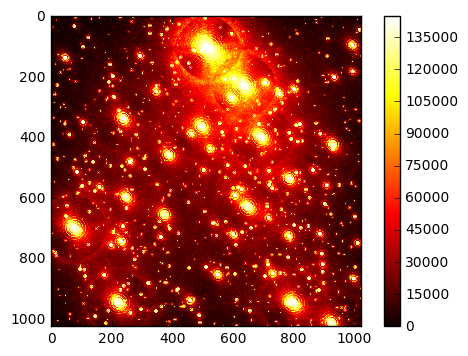

In [4]:
plt.imshow(im[0].data, cmap="hot")
plt.colorbar()

### Some notes on `<im>` and the first simulation

* The default exposure time is 60 seconds
* SimCADO has a safety feature - by default it only reads out a 1024 x 1024 window at the centre of the focal plane
* The default AO mode is SCAO, as we don't yet have access to the MCAO PSFs. This will change soon.

## Saving time by reusing SimCADO internal data

The majority of the time spent by SimCADO is building the optical train and setting up the simulation. You can avoid this by reusing SimCADO's internal data. These include:
* An `<OpticalTrain>` object
* A `<Detector>` object
* A `<UserCommands>` object

In [5]:
im, internals = sim.run(src, return_internals=True)

Using PSF: C:\Program Files\Anaconda3\lib\site-packages\simcado\data\PSF_SCAO.fits
 id x_cen y_cen x_len y_len
--- ----- ----- ----- -----
  0     0     0  1024  1024
Creating 1 layer(s) per chip
1 chip(s) will be simulated
Chip ID: 0 - Creating layer between [um]: 1.933 2.385
Reading out chip 0


`<internals>` includes 3 objects. The next time you run a simulation, remember to include them

In [6]:
cmd, opt, fpa = internals
internals

(<simcado.commands.UserCommands at 0x274989ecc50>,
 <simcado.detector.Detector at 0x27498b2f080>)

In [7]:
im = sim.run(src, cmds=cmd, opt_train=opt, fpa=fpa)

 id x_cen y_cen x_len y_len
--- ----- ----- ----- -----
  0     0     0  1024  1024
Creating 1 layer(s) per chip
1 chip(s) will be simulated
Chip ID: 0 - Creating layer between [um]: 1.933 2.385
Reading out chip 0


### Notes on the internal objects
* If you want to change anything about the optical train, i.e. switch from wide-field to zoom mode, or swap a filter, you need to recreate your `<OpticalTrain>` object. See the documentation for this.
* fpa = Focal Plan Array - it's a `<Detector>` object

### Notes on the `<Source>` objects
`<Source>` objects can also be saved to disk for later so that you don't have to generate a new one every time you want to simulate something.

    >>> im.write("my_cluster.fits")

This can be read in again with the generic `Source` command:

    >>> src = simcado.Source(filename="my_cluster.fits")
    
** Note ** that the keyword `filename=` must be specified as `simcado.Source()` can take several different inputs.

To generate `<Source>` objects, SimCADO provides several other functions. For a full description, refer to the documentation. Such functions are found in **`simcado.source`** module. E.g:

    >>> # Found in simcado.source
    >>> .source_from_image()
    >>> .cluster()
    >>> .stars()
    >>> .star_grid()
    >>> .empty_sky()

### Notes on the simulations
At the heart of it, there are two aspects to simulations
1. Creating an accurate representation of an astronomical object
2. Applying an accurate representation of the optical train to these objects

Point 1 is achieved by using the "Lego" bricks that SimCADO provides to create `<Source>` objects which do a decent job of representing what we want to observe. Later in this notebook we will go into further detail on how to make realistic `<Source>` objects.

Point 2 is achieved by playing with the parameters that control how the `<Source>` object passes through the optical train. This is done primarily by supplying the right keyword-value pairs. The following sections goes into detail:

# Controlling simulations

## Simulating for a full detector array

The function `sim.run()` runs a simulation with all the default parameters. That said, SimCADO has a safety switch to stop you wasting 10 minutes on a `Source` that will be invisible, or so bright that it saturates the detector completely.

To get the full detector array, we set `detector_array="full"`

    >>> im = sim.run(src, detector_array="full")
    
** Note, by patient! ** Simulating 9x 4k detectors is heavy lifting. Remeber to use the internals if you don't plan on changing the optical train.

In [ ]:
# im, (cmd, opt, fpa) = sim.run(src, detector_layout="full", return_internals=True)

### Notes on simcado.run()
There are two parameters still to be covered in detail. Please see the documention (or read the docstring by using `sim.run?`). They are:
* `filename=` : instead of returning the FITS object to the console, save it to disk under this name
* `mode=` : default is "wide" for 4mas imaging. Also accepts "zoom" for 1.5mas imaging mode.


## Viewing a full detector read out

Each chip read-out is stored in a FITS extension. There are 3 options to view the images:
1. Save the FITS object to disk and use DS9, etc
```
>>> im.writeto("full_detector.fits")
```    
2. Use the `filename=` in `simcado.run()` to save directly to disk, and bypass the console. This is useful for scripting with SimCADO.
```
>>> simcado.run(src, filename="full_detector.fits")
```    
3. Use the SimCADO function `.plot_detector()` from the `.detector` module
```
>>> im, (cmd, opt, fpa) = simcado.run(src, filename="full_detector.fits", 
                                         return_internals=True)
>>> simcado.detector.plot_detector(fpa)
```    

The 3rd option is probably the least favourable as there are no options available, but it allows you to see what the readout will look like in a mosaic mode.

## Using KEYWORD=VALUE pairs from the configuration file

SimCADO is controlled with a series of keyword-value pairs contained in a configuration file. **The defaults are the best approximation to MICADO** so changing them is *not* recommended if you want to simulate *MICADO* images. There are however some which are useful to play around with.

**NOTE - SimCADO is CAsE sEnsiTIve**. ALl KEYWORDS are writen with capital letters.

In [8]:
sim.commands.dump_defaults()

#########################################################
##            FREQUENTLY USED KEYWORDS                 ##
#########################################################

#-------------------------------------------------------#
# To dump a file with all keywords, use:                #
# >>>  sim.commands.dump_defaults(filename, type="all") #
#-------------------------------------------------------#

OBS_EXPTIME             60          # [sec] simulated exposure time
OBS_NDIT                1           # [#] number of exposures taken
INST_FILTER_TC          Ks          # [<filename>, string(filter name)] List acceptable filters with >>> simcado.optics.get_filter_set()

ATMO_USE_ATMO_BG        yes         # [yes/no]
SCOPE_USE_MIRROR_BG     yes         # [yes/no]
INST_USE_AO_MIRROR_BG   yes         # [yes/no]
FPA_USE_NOISE           yes         # [yes/no]

FPA_CHIP_LAYOUT         small       # [small/centre/full] description of the chip layout on the detector array. 
SCOPE_PSF_FILE  

Any of the KEYWORD=VALUE pairs can be passed as extras to `sim.run()`. For example if we wanted to observe in J-band for 60 minutes, we would pass:

In [ ]:
src = sim.source.source_1E4_Msun_cluster()
im = sim.run(src, OBS_EXPTIME=3600, INST_FILTER_TC="J")

If we want to see what happens to stars at the edge of the field if the ADC is switched off, we can pass

In [11]:
src = sim.source.source_1E4_Msun_cluster()
im = sim.run(src, INST_FILTER_TC="J", INST_ADC_PERFORMANCE=50)

Using PSF: C:\Program Files\Anaconda3\lib\site-packages\simcado\data\PSF_SCAO.fits
 id x_cen y_cen x_len y_len
--- ----- ----- ----- -----
  0     0     0  1024  1024
Creating 24 layer(s) per chip
1 chip(s) will be simulated
Chip ID: 0 - Creating layer between [um]: 1.04 1.049
Chip ID: 0 - Creating layer between [um]: 1.049 1.06
Chip ID: 0 - Creating layer between [um]: 1.06 1.071
Chip ID: 0 - Creating layer between [um]: 1.071 1.083
Chip ID: 0 - Creating layer between [um]: 1.083 1.095
Chip ID: 0 - Creating layer between [um]: 1.095 1.107
Chip ID: 0 - Creating layer between [um]: 1.107 1.12
Chip ID: 0 - Creating layer between [um]: 1.12 1.133
Chip ID: 0 - Creating layer between [um]: 1.133 1.147
Chip ID: 0 - Creating layer between [um]: 1.147 1.161
Chip ID: 0 - Creating layer between [um]: 1.161 1.176
Chip ID: 0 - Creating layer between [um]: 1.176 1.191
Chip ID: 0 - Creating layer between [um]: 1.191 1.207
Chip ID: 0 - Creating layer between [um]: 1.207 1.224
Chip ID: 0 - Creating la

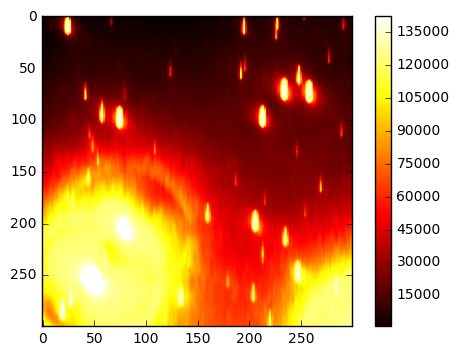

In [14]:
plt.imshow(im[0].data[:300,:300], cmap="hot")
plt.colorbar()

Naturally the ADC will be performing at ~100%, so we don't need to worry about this setting for studying science cases. However it does work well at illustrating how SimCADO generates several different images for different wavelength ranges if there is an effect that is acting in all 3 dimensions (x,y,lam) simultaneously. 

### Note on turning off the background noise

A final note to the control KEYWORDS. There are several that allow us to turn off all the sources of noise. This is handy if we want to check that our objects are actually emitting and their photons are making it to the detector in useful quantities.

    >>> im = sim.run(src, ATMO_USE_ATMO_BG="no", SCOPE_USE_MIRROR_BG="no",
                          INST_USE_AO_MIRROR_BG="no", FPA_USE_NOISE="no")

# Playing with Sources

The `<Source>` object is rather versatile. Rather than containing images of what is on sky, it contains positions of emitting zones. Each emission zone references a spectrum. To save space, many regions can reference the same spectum, but still be unique by how intense they are. Let's learn by example:

Say we want to model a galaxy, we will need an image of a galaxy and a spectrum for that galaxy. 

The image here is a JPEG of a spiral galaxy. We will only take the red channel. The brightest part will be have a weight of 255x my spectrum, the faintest only 1x the spectrum.

In [32]:
# enter a filename to YOUR image here. "spiral.jpg" was pulled from google
gal = spi.imread("spiral.jpg")[:,:,0]

As I don't know anything about galaxies, I will assign a M0V stellar spectrum to this "collection of emission zones". For this I will use SimCADO's built in function `simcado.source.SED()`. However I can use anything, as long as I have an array `lam` for my wavelength bins [in micron] and an array for the SED. As I will be assigning this spectum to an extended source, I should scale it accordingly, so that it becomes 12 mag/arcsec2, and not just 12 mag/pixel.

In [16]:
lam, spec = sim.source.SED("M0V", "Ks", 17)
lam, spec = sim.source.scale_spectrum_sb(lam, spec, mag_per_arcsec=17, filter_name="Ks")

The spectrum doesn't have to be anything special. It could also be a zeros array with a single value of one. For example:

    >>> lam = np.arange(0.7, 2.5)
    >>> spec = np.zeros(len(lam))
    >>> spec[50] = 1
    >>> lam, spec = simcado.source.scale_spectrum(lam, spec, mag=20, filter_name="Ks")

Now that we have a spectrum and an image, we can create a source.

In [17]:
src = sim.source.source_from_image(gal, lam, spec, plate_scale=0.004)

**Note** that we need to provide a plate scale for the image. Ideally the images would already by on the same plate scale as the MICADO mode you're using - i.e. Wide field: 0.004 arcsec, or Zoom: 0.0015 arcsec. If not, then SimCADO will interpolate by a factor given by `oversample`. To ensure proper simulations, `plate_scale / oversample <= 0.004` (for wide field mode).

    >>> src = sim.source.source_from_image(gal, lam, spec, plate_scale=0.1, oversample=25)
    
Because my galaxy image also contains noise, I can tell SimCADO to ignore all values under a certain threshold when it converts the image into a `<Source>` object.

    >>> src = sim.source.source_from_image(gal, lam, spec, plate_scale=0.004, flux_threshold=30)
    
Let's run our galaxy:

In [18]:
im = sim.run(src)

Using PSF: C:\Program Files\Anaconda3\lib\site-packages\simcado\data\PSF_SCAO.fits
 id x_cen y_cen x_len y_len
--- ----- ----- ----- -----
  0     0     0  1024  1024
Creating 1 layer(s) per chip
1 chip(s) will be simulated
Chip ID: 0 - Creating layer between [um]: 1.933 2.385
Reading out chip 0


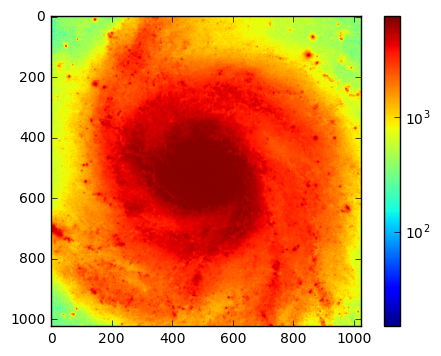

In [19]:
plt.imshow(im[0].data, norm=LogNorm())
plt.colorbar()

## Combining sources

It's all well and good to have a `<Source>` object, but what can you do with just one object. Not much really. But if yu have 2, or 3 or 10 different objects in the observation, then "observing" with SimCADO becomes interesting. To make this happen, `<Source>` object can be added together.

Lets take our cluster from before add at a galaxy to it

In [36]:
lam, spec = sim.source.SED("M0V", "Ks", 17)
lam, spec = sim.source.scale_spectrum_sb(lam, spec, mag_per_arcsec=17, filter_name="Ks")
galaxy = sim.source.source_from_image(gal, lam, spec, plate_scale=0.008, oversample=2,
                                      center_pixel_offset=(1000,1000), conserve_flux=False,
                                      flux_threshold=50)

cluster = sim.source.cluster(mass=1E4, distance=200000, half_light_radius=2)

src = galaxy + cluster

In [37]:
im = sim.run(src, detector_layout="centre")

Using PSF: C:\Program Files\Anaconda3\lib\site-packages\simcado\data\PSF_SCAO.fits
 id x_cen y_cen x_len y_len
--- ----- ----- ----- -----
  0     0     0  4096  4096
Creating 1 layer(s) per chip
1 chip(s) will be simulated
Chip ID: 0 - Creating layer between [um]: 1.933 2.385
Reading out chip 0


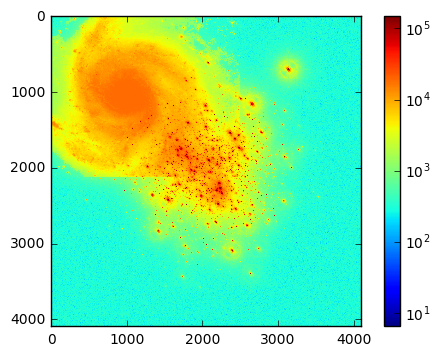

In [38]:
plt.imshow(im[0].data, norm=LogNorm())
plt.colorbar()